In [1]:
import os
import numpy as np
import pandas as pd
import torch
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
from itertools import islice

from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


**Load and Preprocessing Data**

In [2]:
DATA_PATH = '/media/fernandoluizks/HD/Works/Data_Bases/traffic-light-dataset'
os.listdir(DATA_PATH)

['Annotations',
 'daySequence1',
 'daySequence2',
 'dayTrain',
 'nightSequence1',
 'nightSequence2',
 'nightTrain',
 'sample-dayClip6',
 'sample-nightClip1']

In [3]:
PATH = '/media/fernandoluizks/HD/Works/Data_Bases/traffic-light-dataset'

DAY_TRAIN_PATH = '/Annotations/Annotations/dayTrain'
NIGHT_TRAIN_PATH = '/Annotations/Annotations/nightTrain'
FRAMES_DAY_TRAIN_PATH = '/dayTrain/dayTrain'
FRAMES_NIGHT_TRAIN_PATH = '/nightTrain/nightTrain'

In [4]:
def update_filename(filename: str):
    FIRST_PATH, SECOND_PATH = filename.split('/', 1)[1].split('-', 1)
    
    if(FIRST_PATH.startswith('dayClip')):
        return FRAMES_DAY_TRAIN_PATH + '/' + FIRST_PATH + '/frames/' + FIRST_PATH + '-' + SECOND_PATH
    return FRAMES_NIGHT_TRAIN_PATH + '/' + FIRST_PATH + '/frames/' + FIRST_PATH + '-' + SECOND_PATH
    

In [5]:
dayClip = []

for file_name in tqdm((os.listdir(PATH + DAY_TRAIN_PATH))):
    if 'dayClip' in file_name:      
        PATH_FILE = f'{PATH + DAY_TRAIN_PATH}/{file_name}/frameAnnotationsBOX.csv'  
        df = pd.read_csv(PATH_FILE, sep=';')
        dayClip.append(df)
        
dayClip_df = pd.concat(dayClip)
dayClip_df['Filename'] = dayClip_df['Filename'].apply(update_filename)

100%|██████████| 13/13 [00:00<00:00, 19.75it/s]


In [6]:
nightClip = []

for file_name in tqdm((os.listdir(PATH + NIGHT_TRAIN_PATH))):
    if 'nightClip' in file_name:      
        PATH_FILE = f'{PATH + NIGHT_TRAIN_PATH}/{file_name}/frameAnnotationsBOX.csv'  
        df = pd.read_csv(PATH_FILE, sep=';')
        nightClip.append(df)
        
nightClip_df = pd.concat(nightClip)
nightClip_df['Filename'] = nightClip_df['Filename'].apply(update_filename)

100%|██████████| 5/5 [00:00<00:00, 40.98it/s]


In [7]:
df = pd.concat([dayClip_df, nightClip_df])
pd.set_option('display.max_colwidth', None)

df = df.drop(columns=['Origin file', 'Origin track', 'Origin track frame number'])
df.columns = ['filename', 'state', 'xmin', 'ymin', 'xmax', 'ymax', 'frame']

df.shape
df

,filename,state,xmin,ymin,xmax,ymax,frame
0,/dayTrain/dayTrain/dayClip1/frames/dayClip1--00000.jpg,go,698,333,710,358,0
1,/dayTrain/dayTrain/dayClip1/frames/dayClip1--00000.jpg,go,846,391,858,411,0
2,/dayTrain/dayTrain/dayClip1/frames/dayClip1--00001.jpg,go,698,337,710,357,1
3,/dayTrain/dayTrain/dayClip1/frames/dayClip1--00001.jpg,go,847,390,859,410,1
4,/dayTrain/dayTrain/dayClip1/frames/dayClip1--00002.jpg,go,698,331,710,356,2
...,...,...,...,...,...,...,...
3231,/nightTrain/nightTrain/nightClip5/frames/nightClip5--01450.jpg,go,937,221,976,290,1450
3232,/nightTrain/nightTrain/nightClip5/frames/nightClip5--01451.jpg,go,467,36,512,117,1451
3233,/nightTrain/nightTrain/nightClip5/frames/nightClip5--01451.jpg,go,937,219,976,288,1451
3234,/nightTrain/nightTrain/nightClip5/frames/nightClip5--01452.jpg,go,460,33,506,114,1452


In [8]:
df['state'].unique()

array(['go', 'stop', 'stopLeft', 'warning', 'goLeft', 'warningLeft'],
      dtype=object)

In [9]:
# Decrease the number of states

df['state'] = df['state'].replace({'stopLeft' : 'stop', 'goLeft' : 'go', 'warningLeft' : 'warning'})
classes = df['state'].unique()

classes

array(['go', 'stop', 'warning'], dtype=object)

**Features and data visualization**

In [10]:
red_color = (255, 0, 0)
green_color = (0, 255, 0)
blue_color = (0, 0, 255)

def image_bbox(image, bboxes_target = None, bboxes_predicts = None, bboxes_predict_max_score = None, extract_bbox: bool = False) -> None:      
    bbox_image = image[bboxes_target[1]:bboxes_target[3], bboxes_target[0]:bboxes_target[2]].copy()
    
    # Boundings boxes predicts
    if (bboxes_predicts is not None):
        for bboxes_predict in bboxes_predicts:
            cv2.rectangle(image, (int(bboxes_predict[0]), int(bboxes_predict[1])), (int(bboxes_predict[2]), int(bboxes_predict[3])), color=red_color, thickness=2)

    # Bounding box predict (max score)
    if (bboxes_predict_max_score is not None):
        cv2.rectangle(image, (int(bboxes_predict_max_score[0]), int(bboxes_predict_max_score[1])), int((bboxes_predict_max_score[2]), int(bboxes_predict_max_score[3])), color=blue_color, thickness=2)   
    
    # Bounding box target
    cv2.rectangle(image, (int(bboxes_target[0]), int(bboxes_target[1])), (int(bboxes_target[2]), int(bboxes_target[3])), color=(0, 255, 0), thickness=2)   
    
    if extract_bbox:
        return image, bbox_image
        
    return image


In [11]:
def crop_image(image, bbox):
    xmin, ymin, xmax, ymax = bbox
    cropped = image[int(ymin):int(ymax), int(xmin):int(xmax)]
    return cropped

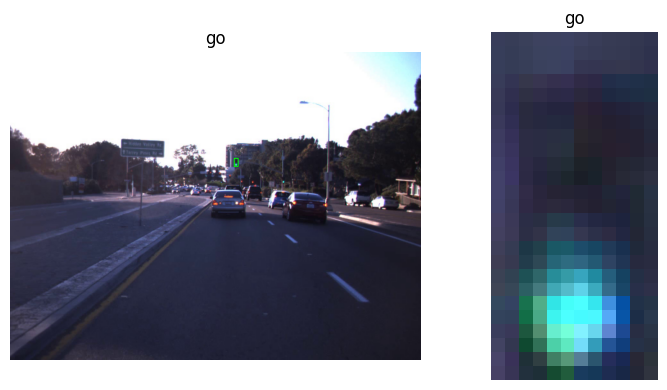

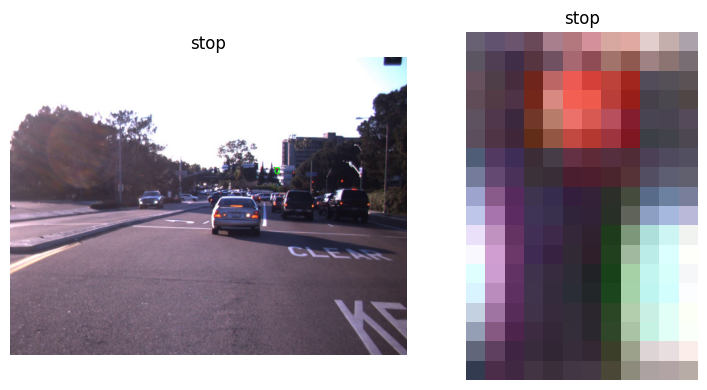

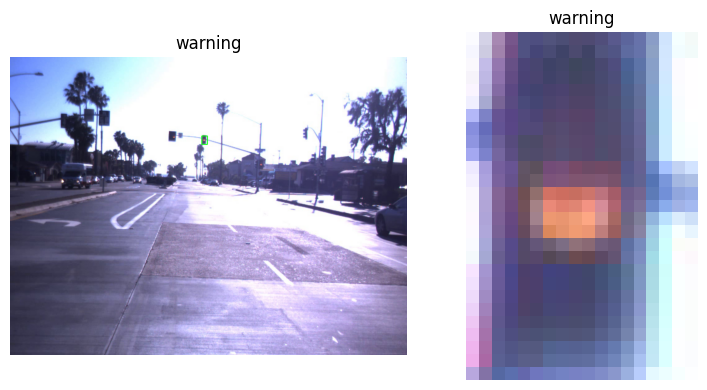

In [12]:
states = df['state'].unique() 

for state in states:
    corresponding_row = df[df['state'] == state].iloc[0]

    image_path = corresponding_row['filename']
    xmin, ymin, xmax, ymax = corresponding_row['xmin'], corresponding_row['ymin'], corresponding_row['xmax'], corresponding_row['ymax']
    bboxes = [xmin, ymin, xmax, ymax]

    image = cv2.imread(PATH + image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    

    image, bbox = image_bbox(image=image_rgb, bboxes_target=bboxes, extract_bbox=True)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].imshow(image)
    axes[0].set_title(state)
    axes[0].axis('off')    

    axes[1].imshow(bbox)
    axes[1].set_title(state)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()


**Dataset and batch configure**

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [14]:
IMAGE_SHAPE = (3, 640, 480)
IMAGE_BB_SHAPE = (3, 28, 12)

class TrafficLightDataset(Dataset):
    def __init__(self, dataframe, transform=None):        
        self.dataframe = dataframe
        self.transform = transform       

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        image_path = row['filename']
        image = cv2.imread(PATH + image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)     
        image_resized = cv2.resize(image_rgb, (IMAGE_SHAPE[1], IMAGE_SHAPE[2]))            
              
        state = row['state']
        state_to_label = {'go': 0, 'warning': 1, 'stop': 2}
        label = state_to_label[state]     

        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

        image_bb = image_rgb[ymin:ymax, xmin:xmax]  
        image_bb_resized = cv2.resize(image_bb, (IMAGE_BB_SHAPE[2], IMAGE_BB_SHAPE[1]))

        width_ratio = IMAGE_SHAPE[1] / image_rgb.shape[1]
        height_ratio = IMAGE_SHAPE[2] / image_rgb.shape[0]

        xmin_resized = int(xmin * width_ratio)
        ymin_resized = int(ymin * height_ratio)
        xmax_resized = int(xmax * width_ratio)
        ymax_resized = int(ymax * height_ratio)

        image_tensor = self.transform(image_resized)      
        image_bb_tensor = self.transform(image_bb_resized) 
        
        boxes = torch.tensor([[xmin_resized, ymin_resized, xmax_resized, ymax_resized]], dtype=torch.float32)
        labels = torch.tensor([label], dtype=torch.int64)

        targets = {
            "boxes": boxes,
            "labels": labels
        }
        return image_tensor, image_bb_tensor, targets
    
transform = transforms.Compose([   
    transforms.ToTensor(), 
])
    
dataset = TrafficLightDataset(dataframe=df, transform=transform)


In [15]:
def collate_fn(batch):
    images, imagesbb, targets = zip(*batch)
    processed_images = []
    processed_images_bb = []
    processed_targets = []

    for image in images:
        processed_images.append(image.to(device))        

    for imagebb in imagesbb: 
        processed_images_bb.append(imagebb.to(device))

    for target in targets:
        processed_targets.append({
            'boxes': target['boxes'].to(device),
            'labels': target['labels'].to(device)
        })       
    
    return list(processed_images), list(processed_images_bb), list(processed_targets)


Split data of training and testing

In [16]:
BATCH_SIZE_TRAIN = 5
BATCH_SIZE_TEST = 1

train_size = int(0.8 * len(dataset)) # 80%
test_size = len(dataset) - train_size # 20%

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(f'TRAIN DATASET SIZE: {len(train_dataset)}  TEST DATASET SIZE: {len(test_dataset)}' )

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False, collate_fn=collate_fn)

TRAIN DATASET SIZE: 41460  TEST DATASET SIZE: 10366


Detection of the bounding box with (FastRRCNN resnet)

In [17]:
model_detector = fasterrcnn_resnet50_fpn(pretrained=True).to(device)
num_classes = 4 

in_features = model_detector.roi_heads.box_predictor.cls_score.in_features
model_detector.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes).to(device)

"""for param in model_detector.parameters():
    param.requires_grad = False

for name, param in model_detector.named_parameters():
    if "layer4" in name or "roi_heads" in name:
        param.requires_grad = True"""

trainable_params = [p for p in model_detector.parameters() if p.requires_grad]
optimizer = optim.Adam([{'params': trainable_params, 'lr': 1e-4},])

/home/fernandoluizks/anaconda3/envs/myEnv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fernandoluizks/anaconda3/envs/myEnv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training loop

In [18]:
NUM_EPOCHS = 1

for epoch in range(NUM_EPOCHS):
    model_detector.train()
    epoch_loss = 0

    for images, _, targets in tqdm(train_loader):          
        predictions = model_detector(images, targets)
        total_loss = sum(predictions.values())

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()

    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {epoch_loss / len(train_loader):.4f}")

100%|██████████| 8292/8292 [3:06:35<00:00,  1.35s/it]  

Epoch [1/1], Loss: 0.0503


Save the trained model detector

In [19]:
model_detector_save_path = "model_detector.pth"

torch.save(model_detector.state_dict(), model_detector_save_path)
print(f"Model save path: {model_detector_save_path}")

Model save path: model_detector.pth


Load the saved model detector

In [20]:
model_detector.load_state_dict(torch.load("model_detector.pth"))
model_detector = model_detector.to(device)
print(model_detector)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

/tmp/ipykernel_3072/3849358030.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_detector.load_state_dict(torch.load("model_detector.pth"))


In [21]:
torch.set_grad_enabled(False)
model_detector.eval()
NUM_SAMPLES = 10

gpu_predictions = []

for _images, _, _targets in tqdm(islice(test_loader, NUM_SAMPLES)):         
    predictions = model_detector(_images)
    batch_data = [{
        'image': img,
        'bboxes_target': targ['boxes'],
        'bboxes_predicts': pred['boxes'], 
        'scores_predicts': pred['scores'] 
    } for img, targ, pred in zip(_images, _targets, predictions)]
    
    gpu_predictions.extend(batch_data)

    del _images, _targets, predictions 
    torch.cuda.empty_cache()

    samples_data_for_batch = []

for data in tqdm(gpu_predictions):
    img = data['image'].permute(1, 2, 0).mul(255).byte().cpu().numpy()
    bboxes_target = data['bboxes_target'].cpu().numpy().astype(int)
    bboxes_predicts = data['bboxes_predicts'].cpu().numpy().astype(int)
    scores_predicts = data['scores_predicts'].cpu().numpy()

    samples_data_for_batch.append({
        'image': img,
        'bboxes_target': bboxes_target,
        'bboxes_predicts': bboxes_predicts,
        'scores_predicts': scores_predicts
    })

10it [00:01,  6.87it/s]
100%|██████████| 10/10 [00:00<00:00, 1387.01it/s]


Visualization of some predicted bounding boxes

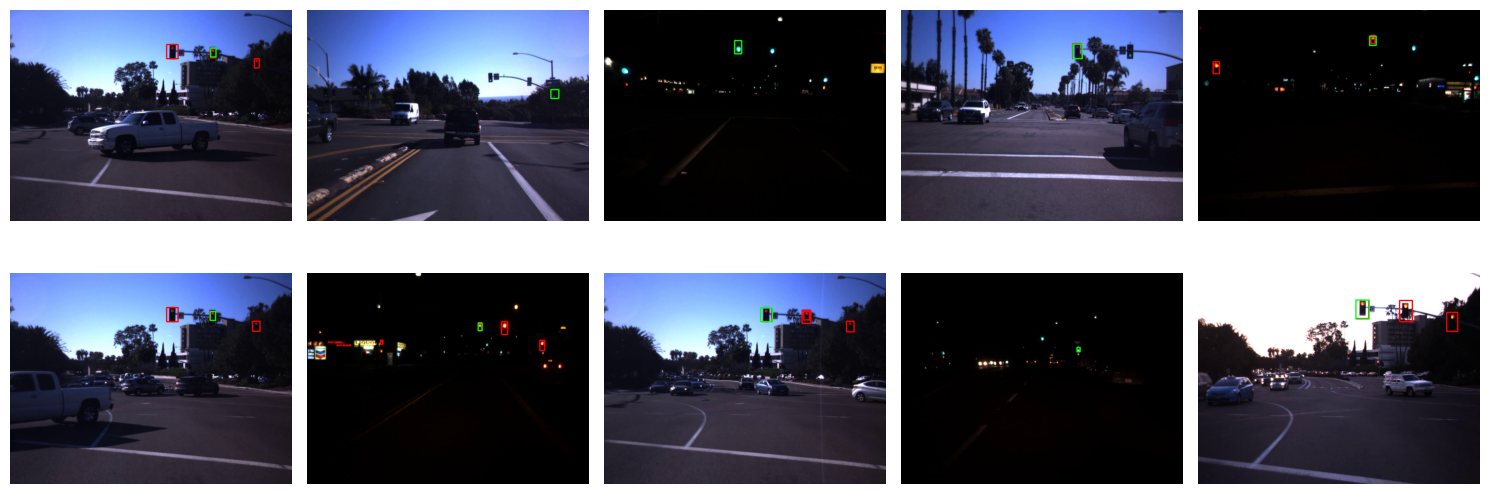

In [22]:
images_samples = []
len_samples = len(samples_data_for_batch)
num_columns = 5
num_rows = len_samples / num_columns 
num_rows = int(num_rows) + (num_rows != int(num_rows))

for sample in samples_data_for_batch:  
    image = sample['image'].copy() 
    processed_image = image_bbox(
        image=image,
        bboxes_target=sample['bboxes_target'][0],
        bboxes_predicts=sample['bboxes_predicts'],
        bboxes_predict_max_score=None,
        extract_bbox=False
    )    
    images_samples.append(processed_image)

fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 3, num_rows * 3))
axes = axes.ravel()

for i, ax in enumerate(axes):   
    ax.imshow(images_samples[i]) 
    ax.axis('off')    

plt.tight_layout()
plt.show()

**Classification**

In [23]:
class TrafficLightClassifier(nn.Module):
    def __init__(self) -> None:
        super(TrafficLightClassifier, self).__init__()

        # First CONV - RELU - POOL
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=(3, 3), stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        # Second CONV - RELU - POOL
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=(3, 3), stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        # Fully Connected Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=10*(IMAGE_BB_SHAPE[1]//4)*(IMAGE_BB_SHAPE[2]//4), out_features=50) 
        self.fc2 = nn.Linear(in_features=50, out_features=3) 
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x) 
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x


In [24]:
model_classificator = TrafficLightClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_classificator.parameters(), lr=0.001)
torch.set_grad_enabled(True) 

In [25]:
NUM_EPOCHS = 2

for epoch in range(NUM_EPOCHS):
    model_classificator.train()
    epoch_loss = 0

    for _, imagesbb, targets in tqdm(train_loader):
        imagesbb = torch.stack(imagesbb).to(device)
        labels = torch.tensor([target['labels'] for target in targets], dtype=torch.long).to(device)

        optimizer.zero_grad()
        predictions = model_classificator(imagesbb)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {epoch_loss / len(train_loader):.4f}")


100%|██████████| 8292/8292 [29:45<00:00,  4.64it/s]


Epoch [1/2], Loss: 0.5657


100%|██████████| 8292/8292 [29:59<00:00,  4.61it/s]

Epoch [2/2], Loss: 0.5540


Save the trained model detector

In [26]:
model_classificator_save_path = "model_classificator.pth"

torch.save(model_classificator.state_dict(), model_classificator_save_path)
print(f"Model save path: {model_classificator_save_path}")

Model save path: model_classificator.pth


Load the trained model detector

In [27]:
model_classificator.load_state_dict(torch.load("model_classificator.pth"))
model_classificator = model_classificator.to(device)
print(model_classificator)

TrafficLightClassifier(
  (conv1): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=210, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)


/tmp/ipykernel_3072/3983430395.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_classificator.load_state_dict(torch.load("model_classificator.pth"))


Inference and avaliation model

In [ ]:
model_classificator.eval()
torch.set_grad_enabled(False) 

correct = 0
total = 0
val_loss = 0

for _, imagesbb, targets in tqdm(test_loader):
        imagesbb = torch.stack(imagesbb).to(device)
        labels = torch.tensor([target['labels'] for target in targets], dtype=torch.long).to(device)

        predictions = model_classificator(imagesbb)
        val_loss += criterion(predictions, labels).item()

        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
average_val_loss = val_loss / len(test_loader)

print(f"Validation Loss: {average_val_loss:.4f}, Accuracy: {accuracy:.2f}%")


100%|██████████| 10366/10366 [07:47<00:00, 22.17it/s]

Validation Loss: 0.5532, Accuracy: 99.83%
